# Multilevel modeling of LFP

This is a slight reworking of the classic Gelman's radon example 

Implementations in:
- tensorflow https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer
- pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html
- stan https://mc-stan.org/users/documentation/case-studies/radon.html
- pyro https://github.com/pyro-ppl/pyro-models/blob/master/pyro_models/arm/radon.py
- numpyro fibrosis dataset http://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html



Why this notebook? It's a common departure point to consider multilevel models in neuroscience.

Hierarchical or multilevel modeling is a generalization of regression modeling. *Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**. Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another. Some multilevel structures are not hierarchical -- e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters. We will motivate this topic using a neuroscience example.

Example: LFP power (modified Gelman and Hill 2006)

LFP power is a measure of neuronal activity. It can varies greatly from mouse to mouse.

The EPA did a study of radon levels in 80,000 households (more on this study and modeling here https://pymc3-testing.readthedocs.io/en/rtd-docs/notebooks/multilevel_modeling.html). We are going to call homes "trials", counties "mice", and radon levels "power." The power is going to vary depending on "no_stim" (originally floor condition) or "stim" (originally basement condition) that in our case denote, say, optogenetic stimulation. There are two important predictors:

* measurement in stim or first no_stim (power higher in stims)
* mouse power level (positive correlation with power levels by mouse)

The hierarchy in this example is neurons within mouse. 



Data: 
- 85 mice
- 2 treatments (stim, no stim)
- 912 trials

When we pool our data, we imply that they are sampled from the same source. This ignores any variation among sampling units (other than sampling variance) -- we assume that mice are all the same:

![pooled](pooled.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that mice have no similarity whatsoever:

![unpooled](unpooled.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](parpooled.png)

Simplification 1 (Complete pooling, ecological):

$$y_i = \alpha + \beta x_i + \epsilon_i$$

Simplification 2 (No pooling, atomistic): 

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$



## We will work toward a partial pooling model with treatment


$$ 
\begin{cases}
    y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i \\
    \alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)
\end{cases}
$$
where $j = 1,\ldots,85$

For this demonstration, we will omit $\beta$s for all examples except last and instead have two intercepts for stim and no-stim:

$$y_i = \alpha^{stim}+\alpha^{no-stim} + x_i + \epsilon_i$$

and

$$y_i = \alpha_{j[i]}^{stim}+\alpha_{j[i]}^{no-stim} + x_i + \epsilon_i$$


## Data organization

First, we import the data from a local file, and extract data.

In [1]:
# HIDE CODE

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import warnings
from theano import tensor as tt

warnings.simplefilter(action="ignore", category=FutureWarning)
RANDOM_SEED = 8924
np.random.seed(286)

In [2]:
# HIDE CODE

az.style.use("arviz-darkgrid")
# Import power data
srrs2 = pd.read_csv(pm.get_data('srrs2.dat'))
srrs2.columns = srrs2.columns.map(str.strip)
# Select a subset of "mice" from Minnesota
srrs_mn = srrs2[srrs2.state=='MN'].copy()

Next, obtain the mouse-level predictor, power, by combining two variables.

In [3]:
# HIDE CODE

srrs_mn['fips'] = srrs_mn.stfips*1000 + srrs_mn.cntyfips
cty = pd.read_csv(pm.get_data('cty.dat'))
cty_mn = cty[cty.st=='MN'].copy()
cty_mn[ 'fips'] = 1000*cty_mn.stfips + cty_mn.ctfips

In [4]:
# HIDE CODE

print(srrs_mn.columns,srrs_mn.shape)
print(cty_mn.columns,cty_mn.shape)

Index(['idnum', 'state', 'state2', 'stfips', 'zip', 'region', 'typebldg',
       'floor', 'room', 'basement', 'windoor', 'rep', 'stratum', 'wave',
       'starttm', 'stoptm', 'startdt', 'stopdt', 'activity', 'pcterr', 'adjwt',
       'dupflag', 'zipflag', 'cntyfips', 'county', 'fips'],
      dtype='object') (919, 26)
Index(['stfips', 'ctfips', 'st', 'cty', 'lon', 'lat', 'Uppm', 'fips'], dtype='object') (89, 8)


Use the `merge` method to combine neuron- and mouse-level information in a single DataFrame.

In [5]:
# HIDE CODE

srrs_mn = srrs_mn.merge(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.drop_duplicates(subset='idnum')
u = np.log(srrs_mn.Uppm).unique()

n = len(srrs_mn)

In [6]:
# HIDE CODE

srrs_mn['Uppm'].unique().shape,srrs_mn['activity'].unique().shape
#plt.scatter(srrs_mn['Uppm'],srrs_mn['activity'])

# HIDE CODE

# Rename environmental variables to represent 
# what we think of as a neuroscience example
srrs_mn.rename({'floor':'no_stim','basement':'stim','county':'mouse',
                'activity':'power'},axis=1,inplace=True)

# HIDE CODE

srrs_mn.head()

,idnum,state,state2,stfips,zip,region,typebldg,no_stim,room,stim,...,stopdt,power,pcterr,adjwt,dupflag,zipflag,cntyfips,mouse,fips,Uppm
0,5081,MN,MN,27,55735,5,1,1,3,N,...,12288,2.2,9.7,1146.499190,1,0,1,AITKIN,27001,0.502054
1,5082,MN,MN,27,55748,5,1,0,4,Y,...,12088,2.2,14.5,471.366223,0,0,1,AITKIN,27001,0.502054
2,5083,MN,MN,27,55748,5,1,0,4,Y,...,21188,2.9,9.6,433.316718,0,0,1,AITKIN,27001,0.502054
3,5084,MN,MN,27,56469,5,1,0,4,Y,...,123187,1.0,24.3,461.623670,0,0,1,AITKIN,27001,0.502054
4,5085,MN,MN,27,55011,3,1,0,4,Y,...,13088,3.1,13.8,433.316718,0,0,3,ANOKA,27003,0.428565


In [7]:
# HIDE CODE

# Rename environmental variables to represent 
# what we think of as a neuroscience example
srrs_mn.rename({'floor':'no_stim','basement':'stim','county':'mouse',
                'activity':'power'},axis=1,inplace=True)

We also need a lookup table (`dict`) for each unique mouse, for indexing.

In [8]:
# HIDE CODE

srrs_mn.mouse = srrs_mn.mouse.map(str.strip)
mn_mice = srrs_mn.mouse.unique()
n_mice = len(mn_mice)
mouse_lookup = dict(zip(mn_mice, range(n_mice)))

Finally, create local copies of variables.

In [9]:
# HIDE CODE

mouse = srrs_mn['mouse_code'] = srrs_mn.mouse.replace(mouse_lookup).values
power = srrs_mn.power
srrs_mn['log_power'] = log_power = np.log(power + 0.1).values
no_stim = srrs_mn.no_stim.values

Distribution of power levels (log scale):

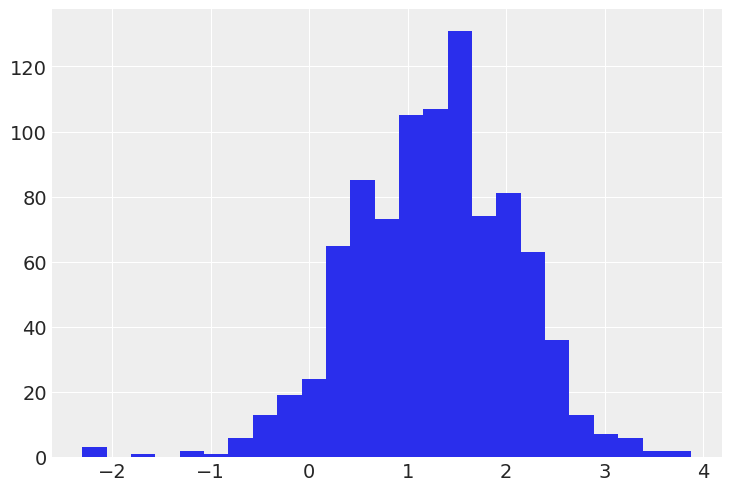

In [10]:
# HIDE CODE

srrs_mn.log_power.hist(bins=25);

## Conventional approaches

The two conventional alternatives to modeling power exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all mice the same, and estimate a single power level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model power in each mouse independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error or variation among trials.

### Complete pooling
One intercept for all (ANOVA, ecological fallacy)

We'll start by estimating the slope and intercept for the complete pooling model. You'll notice that we used an *index* variable instead of an *indicator* variable in the linear model below. There are two main reasons. One, this generalizes well to more-than-two-category cases. Two, this approach correctly considers that neither category has more prior uncertainty than the other. On the contrary, the indicator variable approach necessarily assumes that one of the categories has more uncertainty than the other: here, the cases when `no_stim=1` would take into account 2 priors ($\alpha + \beta$), whereas cases when `no_stim=0` would have only one prior ($\alpha$). But *a priori* we aren't more unsure about no_stim measurements than about stim measurements, so it makes sense to give them the same prior uncertainty.

Now for the model:

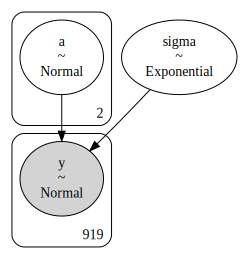

In [11]:
# HIDE CODE

with pm.Model() as pooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=2)
    
    theta = a[no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_power)
    
pm.model_to_graphviz(pooled_model)

Before running the model let's do some prior predictive checks. Indeed, having sensible priors is not only a way to incorporate scientific knowledge into the model, it can also help and make the MCMC machinery faster -- here we are dealing with a simple linear regression, so no link function comes and distorts the outcome space; but one day this will happen to you and you'll need to think hard about your priors to help your MCMC sampler. So, better to train ourselves when it's quite easy than having to learn when it's very hard... There is a really neat function to do that in PyMC3:

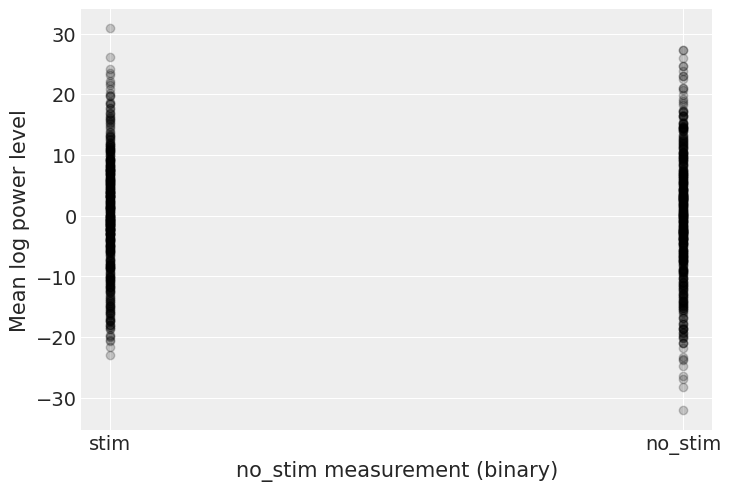

In [12]:
# HIDE CODE

with pooled_model:
    prior_checks = pm.sample_prior_predictive(random_seed=RANDOM_SEED)

plt.plot(
    [0, 1], 
    [prior_checks["a"][:, 0], prior_checks["a"][:, 1]],
    "ok",
    alpha=0.2)
plt.xlabel("no_stim measurement (binary)")
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log power level");

I'm no expert in power levels, but, before seing the data, these priors seem to allow for quite a wide range of the mean log power level. But don't worry, we can always change these priors if sampling gives us hints that they might not be appropriate -- after all, priors are assumptions, not oaths; and as most assumptions, they can be tested.

However, we can already think of an improvement. Do you see it? Remember what we said at the beginning: power levels tend to be higher in stims, so we could incorporate this prior scientific knowledge into our model by giving $a_{stim}$ a higher mean than $a_{no_stim}$. Here, there are so much data that the prior should be washed out anyway, but we should keep this fact in mind -- for future cases or if sampling proves more difficult than expected...

Speaking of sampling, let's fire up the Bayesian machinery!

In [13]:
# HIDE CODE

with pooled_model:
    pooled_trace = pm.fit()

Finished [100%]: Average Loss = 1,154


In [14]:
 
# HIDE CODE

with pooled_model:
    start = pm.find_MAP()
    pooled_trace = pm.sample(1000, pm.NUTS(scaling=start), start=start, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.36,0.03,1.31,1.42,0.0,0.0,5266.08,2963.49,1.0
a[1],0.78,0.06,0.66,0.90,0.0,0.0,5856.73,3357.46,1.0
sigma,0.79,0.02,0.76,0.83,0.0,0.0,5335.04,2973.88,1.0


In [15]:
# HIDE CODE

with pooled_model:
    pooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
az.summary(pooled_trace, round_to=2)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a[0],1.36,0.03,1.31,1.42,0.0,0.0,4702.01,2808.27,1.0
a[1],0.77,0.06,0.65,0.90,0.0,0.0,4962.17,2066.08,1.0
sigma,0.79,0.02,0.76,0.83,0.0,0.0,4176.84,2823.50,1.0


No divergences and a sampling that only took seconds -- this is the Flash of samplers! Here the chains look very good (good R hat, good effective sample size, small sd), but remember to check your chains after sampling -- `az.traceplot` is usually a good start.

Let's see what it means on the outcome space: did the model pick-up the negative relationship between no_stim measurements and log power levels? What's the uncertainty around its estimates? To estimate the uncertainty around the neuron power levels (not the average level, but measurements that would be likely in neurons), we need to sample the likelihood `y` from the model. In another words, we need to do posterior predictive checks:

In [16]:
# HIDE CODE

with pooled_model:
    ppc = pm.sample_posterior_predictive(pooled_trace, random_seed=RANDOM_SEED)["y"]

a_stim, a_no_stim = pooled_trace["a"].mean(axis=0)
power_stim, power_no_stim = ppc[:, 1], ppc[:, 0] # we know that no_stim=0/1 at these columns

We can then use these samples in our plot:

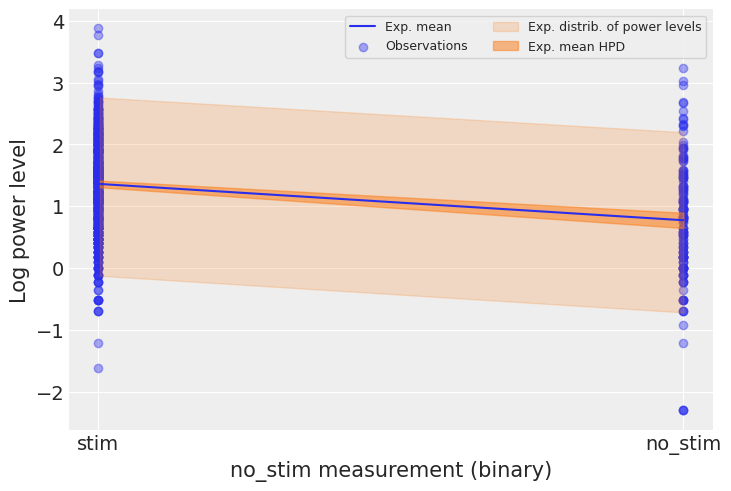

In [17]:
# HIDE CODE

plt.scatter(no_stim, log_power, label="Observations", alpha=0.4)

az.plot_hdi(
    [0, 1], 
    np.asarray([power_stim, power_no_stim]).T, 
    fill_kwargs={"alpha": 0.2, "label": "Exp. distrib. of power levels"},
    show=False
)
az.plot_hdi(
    [0, 1], 
    pooled_trace["a"], 
    fill_kwargs={"alpha": 0.5, "label": "Exp. mean HPD"},
    show=False
)
plt.plot([0, 1], [a_stim, a_no_stim], label="Exp. mean")

plt.xticks([0,1], ["stim", "no_stim"])
plt.xlabel("no_stim measurement (binary)")
plt.ylabel("Log power level")
plt.legend(ncol=2, fontsize=9, frameon=True);

The 94% interval of the expected value is very narrow, and even narrower for stim measurements, meaning that the model is slightly more confident about these observations. The sampling distribution of individual power levels is much wider. We can infer that no_stim level does account for some of the variation in power levels. We can see however that the model underestimates the dispersion in power levels across neurons -- lots of them lie outside the light orange prediction envelope. So this model is a good start but we can't stop there.

Let's compare it to the unpooled model, where we estimate the power level for each mouse:

### Unpooled model
An intercept for [mouse X stim] (ANOVA on trials, atomistic fallacy)

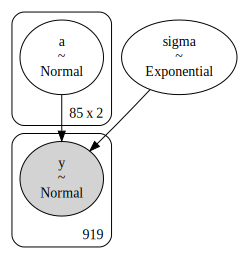

In [18]:
# HIDE CODE

# updated version:
with pm.Model() as unpooled_model:
    a = pm.Normal('a', 0., sigma=10., shape=(n_mice, 2))
    
    theta = a[mouse, no_stim]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_power)

pm.model_to_graphviz(unpooled_model)

In [19]:
# HIDE CODE

with unpooled_model:
    unpooled_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.


Sampling went fine again. Let's look at the expected values for both stim (dimension 0) and no_stim (dimension 1) in each mouse:

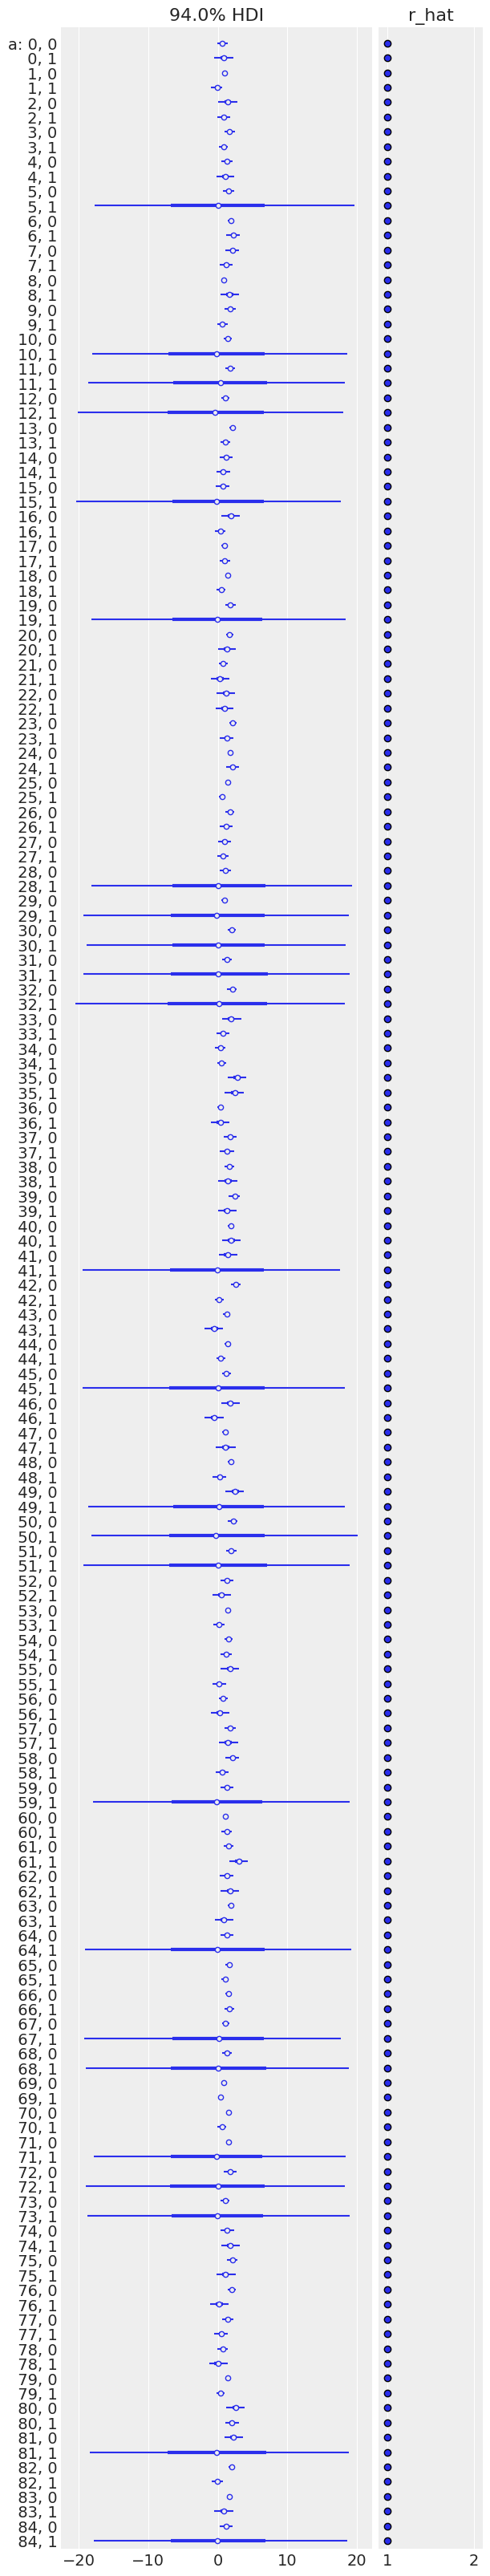

In [20]:
# HIDE CODE

az.plot_forest(unpooled_trace, var_names=['a'], figsize=(6, 32), r_hat=True, combined=True);

Sampling was good for all mice, but you can see that some are more uncertain than others, and all of these uncertain estimates are for no_stim measurements. This probably comes from the fact that some mice just have a handful of no_stim measurements, so the model is pretty uncertain about them.

To identify mice with high power levels, we can plot the ordered mean estimates, as well as their 94% HPD:

In [21]:
# HIDE CODE

a_stim_unpooled, a_no_stim_unpooled = unpooled_trace["a"][:, :, 0], unpooled_trace["a"][:, :, 1]
unpooled_stim = pd.DataFrame.from_dict(
                        {
                            "stim": a_stim_unpooled.mean(0), 
                            "low": az.hdi(a_stim_unpooled)[:, 0], 
                            "high": az.hdi(a_stim_unpooled)[:, 1]
                        }, 
                        orient="index", 
                        columns=mn_mice
                    ).T.sort_values(by="stim")
unpooled_no_stim = pd.DataFrame.from_dict(
                    {
                        "no_stim": a_no_stim_unpooled.mean(0),
                        "low": az.hdi(a_no_stim_unpooled)[:, 0], 
                        "high": az.hdi(a_no_stim_unpooled)[:, 1]
                    }, 
                    orient="index", 
                    columns=mn_mice
                ).T.sort_values(by="no_stim")

<ipython-input-22-87ed4842d845>:9: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


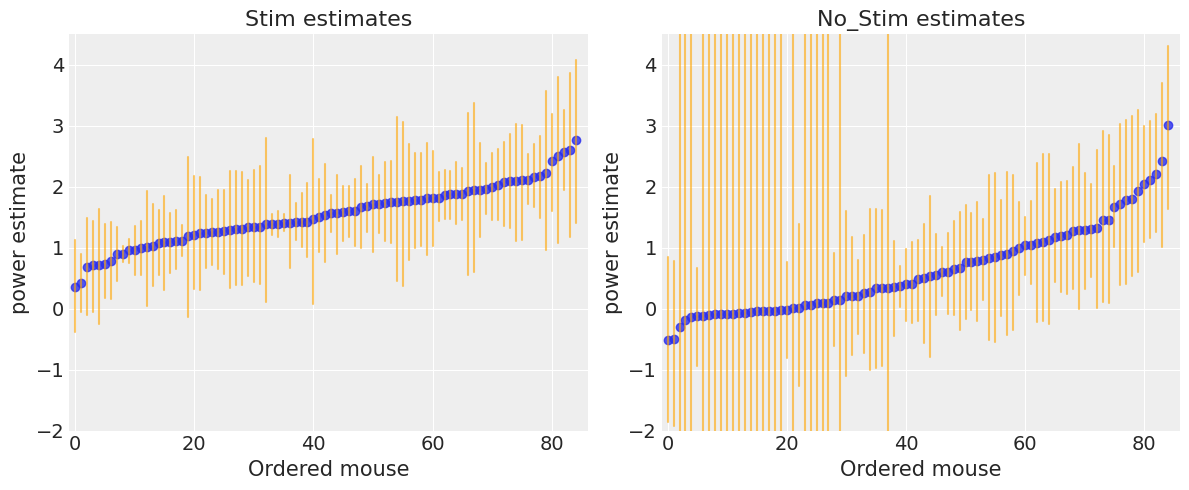

In [22]:
# HIDE CODE

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, estimates, level in zip(axes, [unpooled_stim, unpooled_no_stim], ["stim", "no_stim"]):    
    for i, l, h in zip(range(n_mice), estimates.low.values, estimates.high.values):
        ax.plot([i, i], [l, h], alpha=0.6, c='orange')
    ax.scatter(range(n_mice), estimates[level], alpha=0.8)
    ax.set(title=f"{level.title()} estimates", xlabel="Ordered mouse", xlim=(-1, 86), ylabel="power estimate", ylim=(-2, 4.5))
plt.tight_layout();

There seems to be more dispersion in power levels for no_stim measurements than for stim ones. Moreover, as we saw in the forest plot, no_stim estimates are globally more uncertain, especially in some mice. We speculated that this is due to smaller sample sizes in the data, but let's verify it!

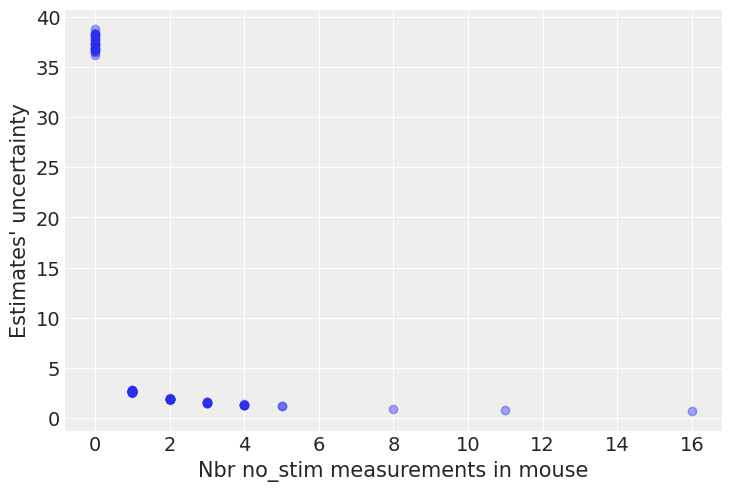

In [23]:
# HIDE CODE

n_no_stim_meas = srrs_mn.groupby("mouse").sum().no_stim
uncertainty = (unpooled_no_stim.high - unpooled_no_stim.low).sort_index() # sort index to match counties alphabetically

plt.plot(n_no_stim_meas, uncertainty, 'o', alpha=.4)
plt.xlabel("Nbr no_stim measurements in mouse")
plt.ylabel("Estimates' uncertainty");

Bingo! This makes sense: it's very hard to estimate no_stim power levels in mice where there are no no_stim measurements, and the model is telling us that by being very uncertain in its estimates for those mice. This is a classic issue with no-pooling models: when you estimate clusters independently from each other, what do you with small-sample-size mice?

Another way to see this phenomenon is to visually compare the pooled and unpooled estimates for a subset of mice representing a range of sample sizes:

<ipython-input-24-7623f5ddb0dd>:29: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


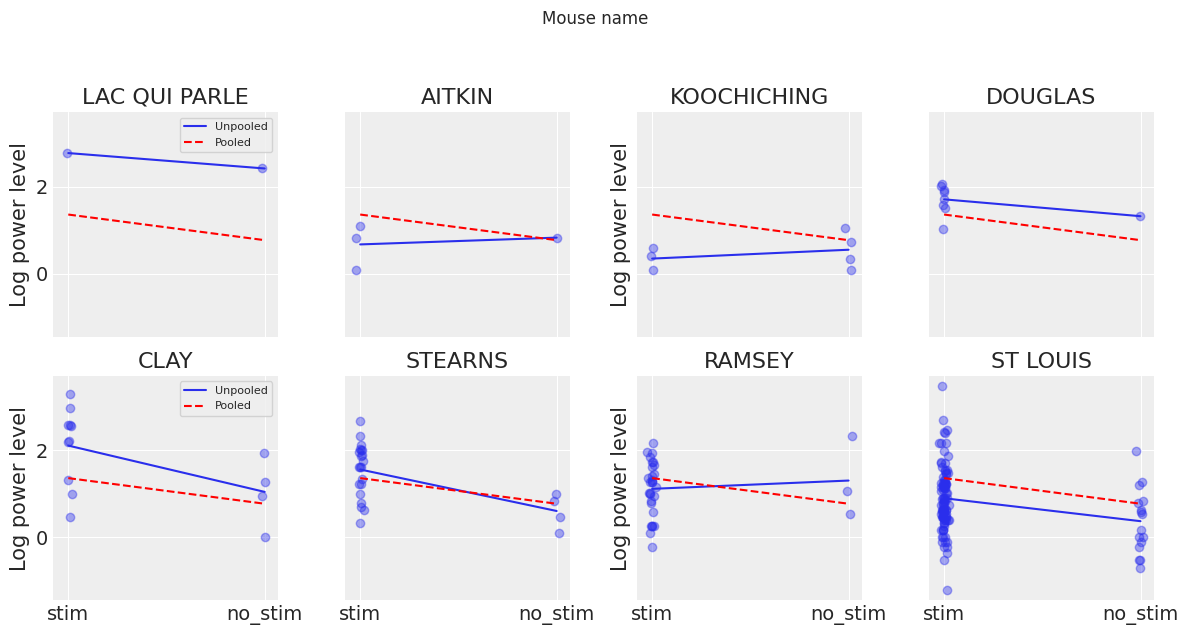

In [24]:
# HIDE CODE

# These mice were named as counties in Minnesota, how curious
SAMPLE_mice = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel() 
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_power[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # plot both models:
    axes[i].plot([0, 1], [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]], label='Unpooled')
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--",  label='Pooled')
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log power level")
    
    if not i%4:
        axes[i].legend(fontsize=8, frameon=True)
plt.suptitle('Mouse name', y=1.05)
plt.tight_layout();

Neither of these models are satisfactory:

* If we are trying to identify high-power mice, pooling is useless -- because, by definition, the pooled model estimates power at the cohort-level. In other words, pooling leads to maximal *underfitting*: the variation across mice is not taken into account and only the overall population is estimated.
* We do not trust extreme unpooled estimates produced by models using few observations. This leads to maximal *overfitting*: only the within-mouse variations are taken into account and the overall population (i.e the cohort-level, which tells us about similarites across mice) is not estimated. 

This issue is acute for small sample sizes, as seen above: in mice where we have few no_stim measurements, if power levels are higher for those data points than for stim ones (Aitkin, Koochiching, Ramsey), the model will estimate that power levels are higher in no_stims than stims for these mice. But we shouldn't trust this conclusion, because both scientific knowledge and the situation in other mice tell us that it is usually the reverse (stim power > no_stim power). So unless we have a lot of observations telling us otherwise for a given mouse, we should be skeptical and shrink our mouse-estimates to the cohort-estimates -- in other words, we should balance between cluster-level and population-level information, and the amount of shrinkage will depend on how extreme and how numerous the data in each cluster are. 

But how do we do that? Well, ladies and gentlemen, let me introduce you to... hierarchical models!

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance) -- we assume that mice are all the same:

![pooled](pooled.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are too large to combine them -- we assume that mice have no similarity whatsoever:

![unpooled](unpooled.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***partial pooling***:

![hierarchical](parpooled.png)


We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model without treatment

The simplest partial pooling model for the neuron power dataset is one which simply estimates power levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled mouse estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for mice with smaller sample sizes will shrink towards the cohort-wide average.

Estimates for mice with larger sample sizes will be closer to the unpooled mouse estimates and will influence the the cohort-wide average.

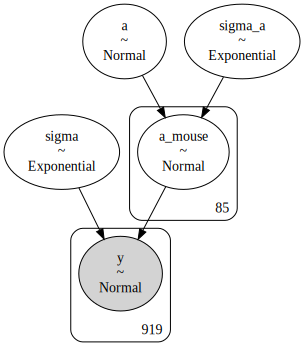

In [25]:
# HIDE CODE

with pm.Model() as partial_pooling:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    
    # Expected value per mouse:
    theta = a_mouse[mouse]
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_power)
pm.model_to_graphviz(partial_pooling)

In [26]:
# HIDE CODE

with partial_pooling:
    partial_pooling_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, a_mouse, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.


The number of effective samples is smaller than 25% for some parameters.


To compare partial-pooling and no-pooling estimates, let's run the unpooled model without the `no_stim` predictor:

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, a_mouse]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


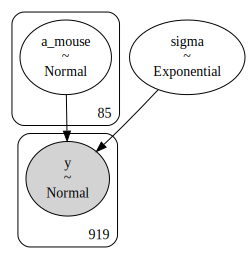

In [27]:
# HIDE CODE

with pm.Model() as unpooled_bis:
    a_mouse = pm.Normal('a_mouse', 0., sigma=10., shape=n_mice)
    
    theta = a_mouse[mouse]
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_power)
    
    unpooled_trace_bis = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)
pm.model_to_graphviz(unpooled_bis)

Now let's compare both models' estimates for all 85 mice. We'll plot the estimates against each mouse's sample size, to let you see more clearly what hierarchical models bring to the table:

<ipython-input-28-fe10ec1a3dc4>:33: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


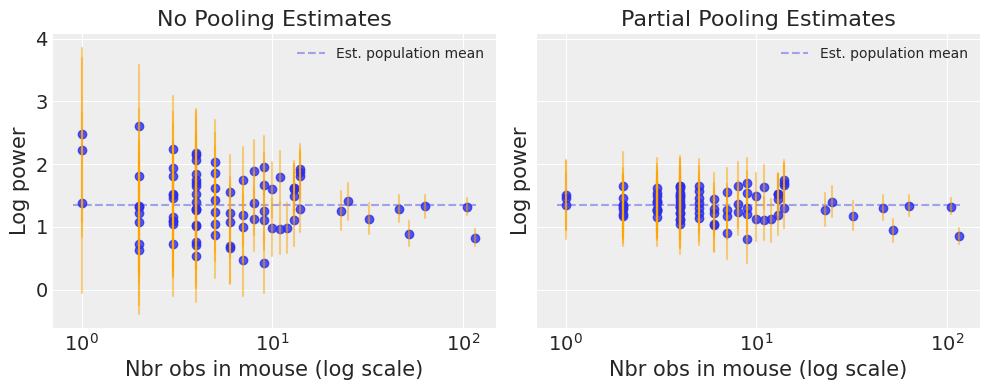

In [28]:
# HIDE CODE

N_mouse = srrs_mn.groupby("mouse")["idnum"].count().values

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes, 
    [unpooled_trace_bis["a_mouse"], partial_pooling_trace["a_mouse"]], 
    ["no pooling", "partial pooling"]
):
    ax.hlines(
        partial_pooling_trace["a"].mean(), 
        0.9, 
        max(N_mouse) + 1, 
        alpha=0.4, 
        ls="--", 
        label="Est. population mean"
    )
    for n, l, h in zip(
        N_mouse, 
        az.hdi(trace)[:, 0], 
        az.hdi(trace)[:, 1]
    ):
        ax.plot([n, n], [l, h], alpha=0.5, c="orange")
    ax.scatter(N_mouse, trace.mean(0), alpha=0.8)
    ax.set(
        title=f"{level.title()} Estimates", 
        xlabel="Nbr obs in mouse (log scale)", 
        xscale="log", 
        ylabel="Log power"
    )
    ax.legend(fontsize=10)
plt.tight_layout();

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes: As expected, the former are both more extreme and more imprecise. Indeed, in the partially-pooled model, estimates in small-sample-size mice are informed by the population parameters -- hence more precise estimates. Moreover, the smaller the sample size, the more regression towards the overall mean (the dashed gray line) -- hence less extreme estimates. In other words, the model is skeptical of extreme deviations from the population mean in mice where data is sparse. 

Now let's try to integrate the `no_stim` predictor! To show you an example with a slope we're gonna take the indicator variable road, but we could stay with the index variable approach that we used for the no-pooling model. Then we would have one intercept for each category -- stim and no_stim.

## Full model: Partial pooling with treatment

As above, this model allows intercepts to vary across mouse, according to a random effect. We just add a fixed slope for the predictor (i.e all mice will have the same slope):

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the no-pooling model, we set a separate intercept for each mouse, but rather than fitting separate regression models for each mouse, multilevel modeling **shares strength** among mice, allowing for more reasonable inference in mice with little data. Here is what that looks in code:

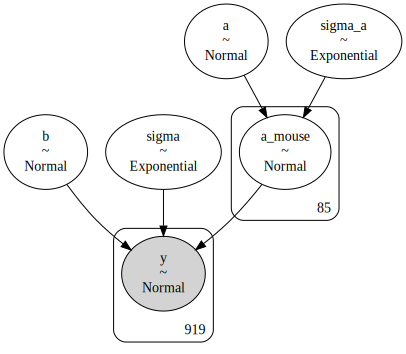

In [29]:
# HIDE CODE

with pm.Model() as varying_intercept:
    # Hyperpriors:
    a = pm.Normal('a', mu=0., sigma=10.)
    sigma_a = pm.Exponential('sigma_a', 1.)
    
    # Varying intercepts:
    a_mouse = pm.Normal('a_mouse', mu=a, sigma=sigma_a, shape=n_mice)
    # Common slope:
    b = pm.Normal('b', mu=0., sigma=10.)
    
    # Expected value per mouse:
    theta = a_mouse[mouse] + b * no_stim
    # Model error:
    sigma = pm.Exponential('sigma', 1.)
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_power)
pm.model_to_graphviz(varying_intercept)

Let's fit this bad boy with MCMC:

In [30]:
# HIDE CODE

with varying_intercept:
    varying_intercept_trace = pm.sample(1000, tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...


Initializing NUTS using jitter+adapt_diag...


Multiprocess sampling (4 chains in 4 jobs)


NUTS: [sigma, b, a_mouse, sigma_a, a]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 7 seconds.


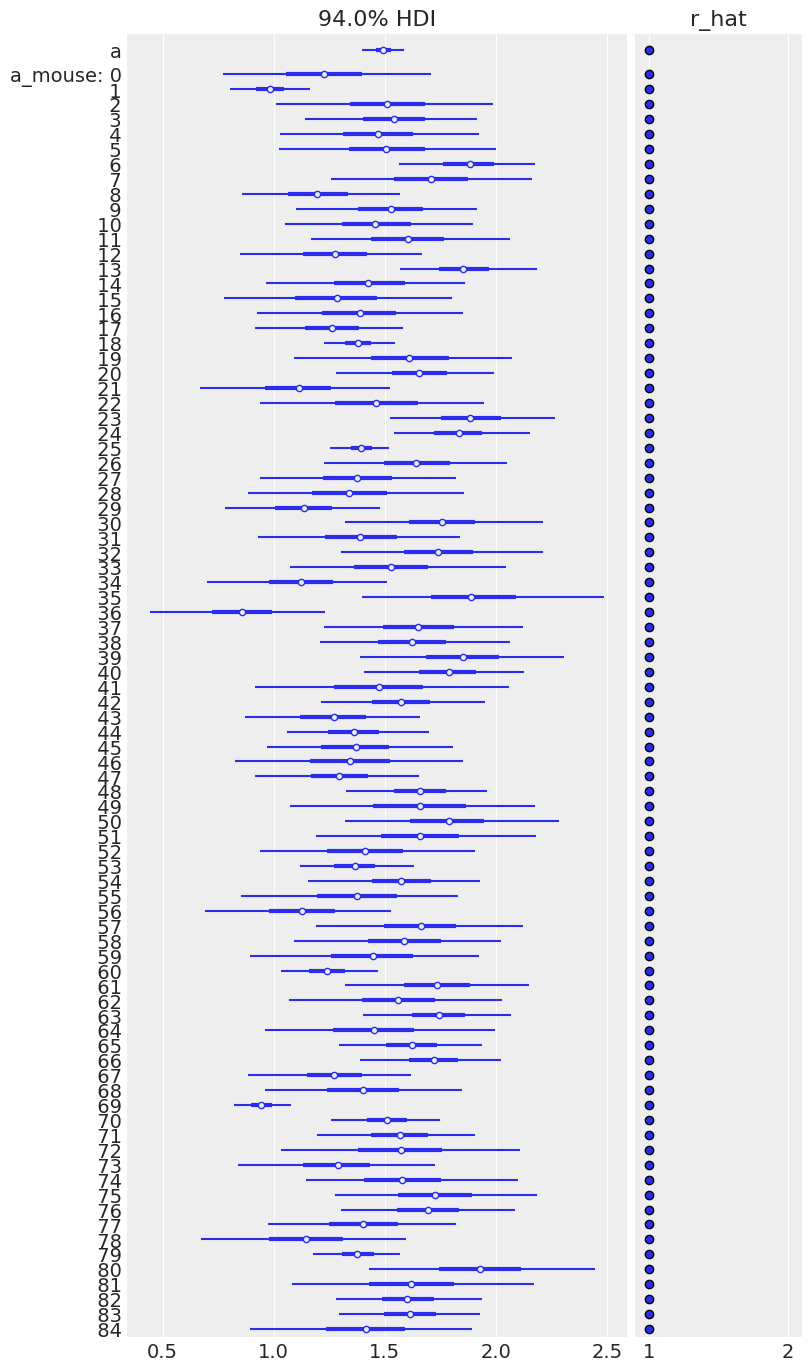

In [31]:
# HIDE CODE

az.plot_forest(varying_intercept_trace, var_names=["a", "a_mouse"], r_hat=True, combined=True);

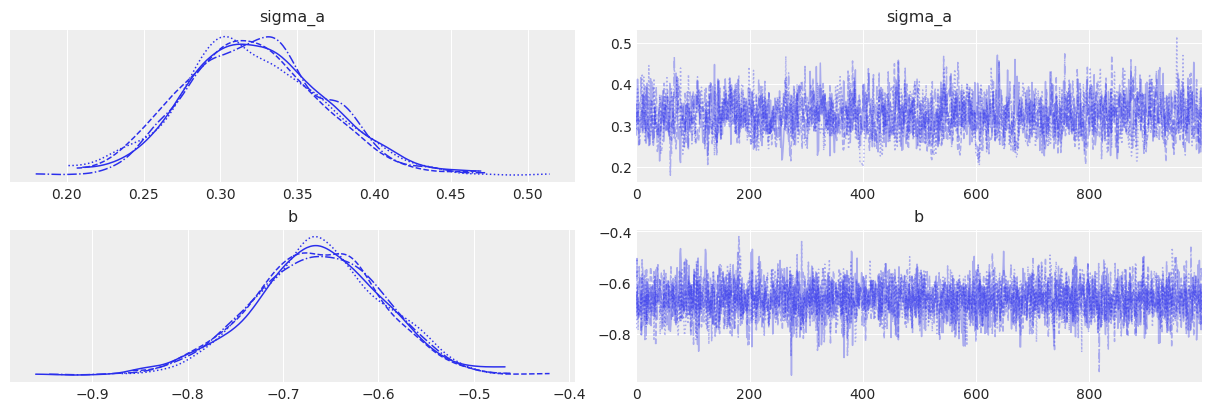

In [32]:
# HIDE CODE

az.plot_trace(varying_intercept_trace, var_names=["sigma_a", "b"]);

In [33]:
# HIDE CODE

az.summary(varying_intercept_trace, var_names=["a", "sigma_a", "b", "sigma"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,1.49,0.05,1.40,1.59,0.0,0.0,2258.17,2569.27,1.00
sigma_a,0.32,0.04,0.24,0.41,0.0,0.0,1212.96,1615.95,1.01
b,-0.66,0.07,-0.80,-0.54,0.0,0.0,3302.85,2909.08,1.00
sigma,0.73,0.02,0.69,0.76,0.0,0.0,5015.66,2859.70,1.00


As we suspected, the estimate for the `no_stim` coefficient is reliably negative and centered around -0.66. This can be interpreted as neurons without stims having about half ($\exp(-0.66) = 0.52$) the power levels of those with stims, after accounting for mouse. Note that this is only the *relative* effect of no_stim on power levels: conditional on being in a given mouse, power is expected to be half lower in neurons without stims than in neurons with. To see how much difference a stim makes on the *absolute* level of power, we'd have to push the parameters through the model, as we do with posterior predictive checks and as we'll do just now.

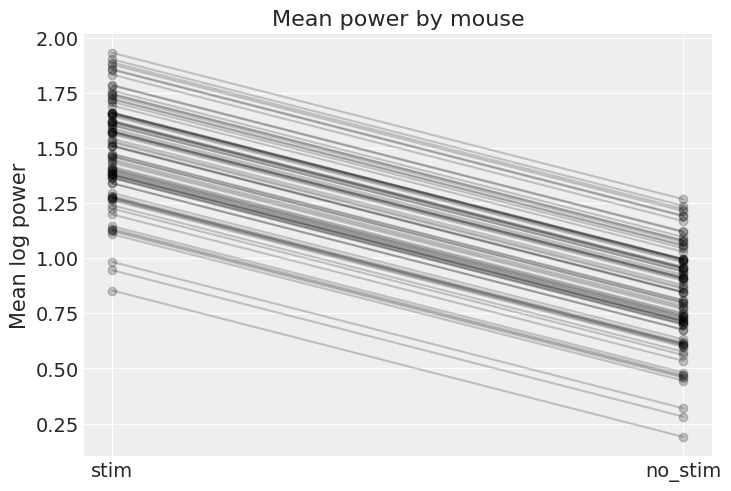

In [34]:
# HIDE CODE

xvals = np.arange(2)
avg_a_mouse = varying_intercept_trace["a_mouse"].mean(0)
avg_b = varying_intercept_trace["b"].mean()

for a_c in avg_a_mouse:
    plt.plot(xvals, a_c + avg_b * xvals, 'ko-', alpha=0.2)
plt.xticks([0,1], ["stim", "no_stim"])
plt.ylabel("Mean log power")
plt.title("Mean power by mouse");

The graph above shows, for each mouse, the expected log power level and the average effect of having no stim -- these are the absolute effects we were talking about. Two caveats though:
1. This graph doesn't show the uncertainty for each mouse -- how confident are we that the average estimates are where the graph shows? For that we'd need to combine the uncertainty in `a_mouse` and `b`, and this would of course vary by mouse. I didn't show it here because the graph would get cluttered, but go ahead and do it for a subset of mice.
2. These are only *average* estimates at the *mouse-level* (`theta` in the model): they don't take into account the variation by neuron. To add this other layer of uncertainty we'd need to take stock of the effect of `sigma` and generate samples from the `y` variable to see the effect on given neurons (that's exactly the role of posterior predictive checks).

That being said, it is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for mice with small sample sizes:

<ipython-input-35-f22af32deafd>:35: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout();


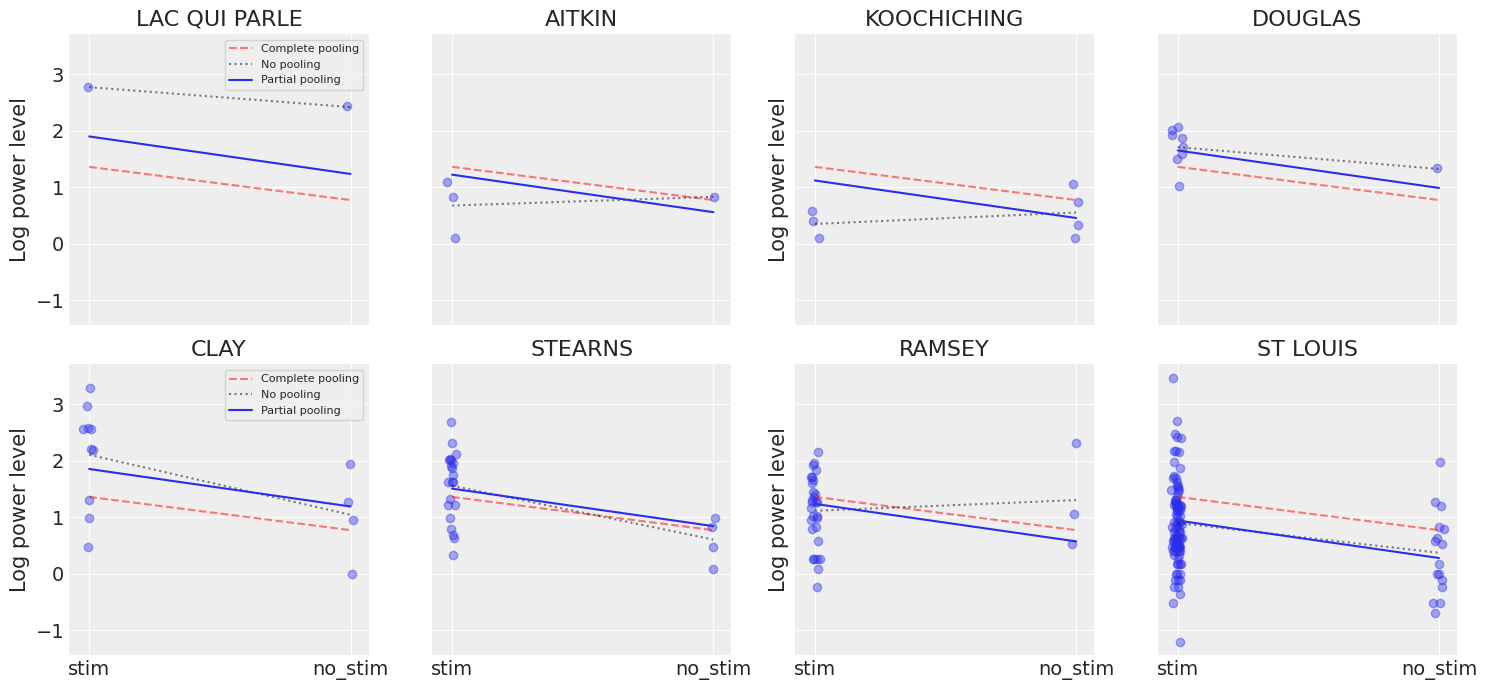

In [35]:
# HIDE CODE

fig, axes = plt.subplots(2, 4, figsize=(15, 7), sharey=True, sharex=True)
axes = axes.ravel()
for i, c in enumerate(SAMPLE_mice):
    x = srrs_mn.no_stim[srrs_mn.mouse==c]
    y = srrs_mn.log_power[srrs_mn.mouse==c]
    
    # plot obs:
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    # complete-pooling model:
    axes[i].plot([0, 1], [a_stim, a_no_stim], "r--", alpha=0.5, label="Complete pooling")
    # no-pooling model:
    axes[i].plot(
        [0, 1], 
        [unpooled_stim.loc[c, "stim"] , unpooled_no_stim.loc[c, "no_stim"]],
        "k:",
        alpha=0.5,
        label="No pooling"
    )
    # partial-pooling model:
    axes[i].plot(
        [0, 1], 
        [avg_a_mouse[mouse_lookup[c]], avg_a_mouse[mouse_lookup[c]] + avg_b],
        label="Partial pooling"
    )
    
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(["stim", "no_stim"])
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel("Log power level")
    if not i%4:
        axes[i].legend(fontsize=8, frameon=True)
plt.tight_layout();

Here we clearly see the notion that partial-pooling is a compromise between no pooling and complete pooling, as its mean estimates are usually between the other models' estimates. And interestingly, the bigger (smaller) the sample size in a given mouse, the closer the partial-pooling estimates are to the no-pooling (complete-pooling) estimates.

We see however that mice vary by more than just their baseline rates: the effect of no_stim seems to be different from one mouse to another. It would be great if our model could take that into account, wouldn't it? Well to do that, we need to allow the slope to vary by mouse -- not only the intercept -- and here is how you can do it with PyMC3.

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data.

- Estimation of coefficients for (under-represented) groups.

- Incorporating individual- and group-level information when estimating group-level coefficients.

- Allowing for variation among individual-level coefficients across groups.

## References

- Gelman, A., & Hill, J. (2006), *Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.)*, Cambridge University Press.

- Gelman, A. (2006), *Multilevel (Hierarchical) modeling: what it can and cannot do*, Technometrics, 48(3), 432–435.

- McElreath, R. (2020), *Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.)*, CRC Press. 